In [1]:
# Core libraries
import pandas as pd
import numpy as np
import os # Provides a way to interact with the operating system, like navigating directories.
import zipfile #This section is to convert the uploaded zip files into folders

# Machine Learning
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RepeatedKFold

# Statistical Analysis
from scipy.stats import pearsonr

# Visualization
import matplotlib.pyplot as plt

# Deep Learning (Imported but not explicitly used in subsequent cells)
import torch

In [2]:
# Define the paths to your zip files
zip_files = ["Exp1.zip", "Exp2.zip", "Analysis.zip"]

# Define the directory where you want to extract the files
extract_dir = "/content/" # You can change this if you want to extract elsewhere

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract each zip file
for zip_file in zip_files:
    if os.path.exists(zip_file):
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Extracted {zip_file} to {extract_dir}")
    else:
        print(f"Error: {zip_file} not found.")

Extracted Exp1.zip to /content/
Extracted Exp2.zip to /content/
Extracted Analysis.zip to /content/


# Process text

In [3]:
#This is generating the prompts for each section
#We have 2 sections of discrete and dimensional
#Each section has 2 subsections of perceived and induced
discrete_tags = ["happiness", "sadness", "anger", "tenderness", "fear"]

discrete_captions_perceived = ["I perceive this sound as " + tag for tag in discrete_tags]
print(discrete_captions_perceived)
discrete_captions_induced = ["This sound makes me feel " + tag for tag in discrete_tags]
print(discrete_captions_induced)

dimensional_tags = ["positive", "relaxed", "awake"]

dimensional_captions_perceived = ["I perceive this sound as " + tag for tag in dimensional_tags]
print(dimensional_captions_perceived)
dimensional_captions_induced = ["This sound makes me feel " + tag for tag in dimensional_tags]
print(dimensional_captions_induced)


['I perceive this sound as happiness', 'I perceive this sound as sadness', 'I perceive this sound as anger', 'I perceive this sound as tenderness', 'I perceive this sound as fear']
['This sound makes me feel happiness', 'This sound makes me feel sadness', 'This sound makes me feel anger', 'This sound makes me feel tenderness', 'This sound makes me feel fear']
['I perceive this sound as positive', 'I perceive this sound as relaxed', 'I perceive this sound as awake']
['This sound makes me feel positive', 'This sound makes me feel relaxed', 'This sound makes me feel awake']


## Load csv files and extract related columns

In [4]:
IDim_path = '/content/Exp1/Data/IDim'
IDim_response_dfs = []

for file in os.listdir(IDim_path):
    if file.endswith(".csv"):
        file_path = os.path.join(IDim_path, file)
        try:
            df = pd.read_csv(file_path, sep=r'\s*,\s*', engine='python')
            # Crucial: Strip whitespace from column names
            df.columns = df.columns.str.strip()

            # Ensure required rating columns exist
            required_cols = ['positive', 'relaxed', 'awake']
            if all(col in df.columns for col in required_cols):
                # Select only the relevant columns and append to our list
                IDim_response_dfs.append(df[required_cols])
            else:
                print(f"Skipping file '{file_path}': Missing required columns ({required_cols}). Found columns: {df.columns.tolist()}")

        except Exception as e:
            print(f"Error reading or processing file {file_path}: {e}")


# Concatenate all individual DataFrames into one master DataFrame for human responses
if IDim_response_dfs:
    master_human_responses_df = pd.concat(IDim_response_dfs, ignore_index=True)
    print(f"Master human responses DataFrame shape: {master_human_responses_df.shape}\n")
    print(f"Master human responses (first 5 rows):\n{master_human_responses_df.head()}\n")
else:
    raise ValueError("No valid CSV files found or processed in IDim_path.")


Master human responses DataFrame shape: (3835, 3)

Master human responses (first 5 rows):
   positive  relaxed  awake
0      4.98     4.98   4.99
1      3.94     5.02   4.96
2      5.51     5.03   5.02
3      4.93     5.05   4.97
4      4.43     4.44   4.95



In [5]:
# Step 1: Load timbre data
timbre_path = "/content/Analysis/Thesis_Ch5/TimbreToolbox/long_AT1_TimbreToolbox_220509.csv"
df = pd.read_csv(timbre_path)
df.columns = df.columns.str.strip()

# Step 2: Extract first 59 unique audio files
unique_stims = df['stim'].drop_duplicates().iloc[1:60]
audio_df = df[df['stim'].isin(unique_stims)].copy()

# =Step 3: Group by audio ('stim') and average participant ratings
response_cols = ['positive', 'relaxed', 'awake']
available_responses = [col for col in response_cols if col in audio_df.columns]
if not available_responses:
    raise ValueError("❌ No 'positive', 'relaxed', or 'awake' columns found in data.")

response_avg = audio_df.groupby('stim')[available_responses].mean()

# Step 4: Extract features starting from 'IQR_Pitch' onwards
start_col = audio_df.columns.get_loc('IQR_Pitch')
feature_cols = audio_df.columns[start_col:]

# Group by stim and average those numerical features
features_avg = audio_df.groupby('stim')[feature_cols].mean()

# Step 5: Align features and labels
X = features_avg
Y = response_avg

# Standardize features
scaler = StandardScaler()
X = X.dropna()  # Drop any rows with NaNs
Y = Y.loc[X.index]  # Align Y with cleaned X
X_scaled = scaler.fit_transform(X)



## Training the model

In [6]:
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

lasso_models = {}
lasso_predictions = {}

for col in Y.columns:
    y = Y[col].values

    all_y_true, all_y_pred, all_models = [], [], []

    for train_idx, test_idx in rkf.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = LassoCV(cv=5, random_state=42).fit(X_train, y_train)
        y_pred = model.predict(X_test)

        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_models.append(model)

    # Store only the last model (for alpha, coef access) + all predictions
    lasso_models[col] = model
    lasso_predictions[col] = {
        'y_true': np.array(all_y_true),
        'y_pred': np.array(all_y_pred),
        'models': all_models  # Optional: keep all models for analysis
    }

    print(f"✅ Lasso model trained for: {col} (avg α = {np.mean([m.alpha_ for m in all_models]):.5f})")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.316e-03, tolerance: 4.958e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.991e-02, tolerance: 4.958e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.218e-02, tolerance: 4.958e

✅ Lasso model trained for: positive (avg α = 0.11159)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.880e-02, tolerance: 5.539e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.983e-02, tolerance: 5.539e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.020e-02, tolerance: 5.539e

✅ Lasso model trained for: relaxed (avg α = 0.20981)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.644e-03, tolerance: 1.749e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.364e-03, tolerance: 1.749e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.551e-03, tolerance: 1.749e

✅ Lasso model trained for: awake (avg α = 0.06728)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.338e-03, tolerance: 2.602e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.668e-03, tolerance: 2.602e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.053e-03, tolerance: 2.602e

## Testing the model


✅✅ Training Complete!
→ Number of audio samples used: 56
→ Number of features per sample: 54
→ Feature names (first 5): ['IQR_Pitch', 'IQR_HarmonicSpectralDeviation', 'IQR_Tristimulus_1', 'IQR_Tristimulus_2', 'IQR_Tristimulus_3']
→ Target dimensions: ['positive', 'relaxed', 'awake']


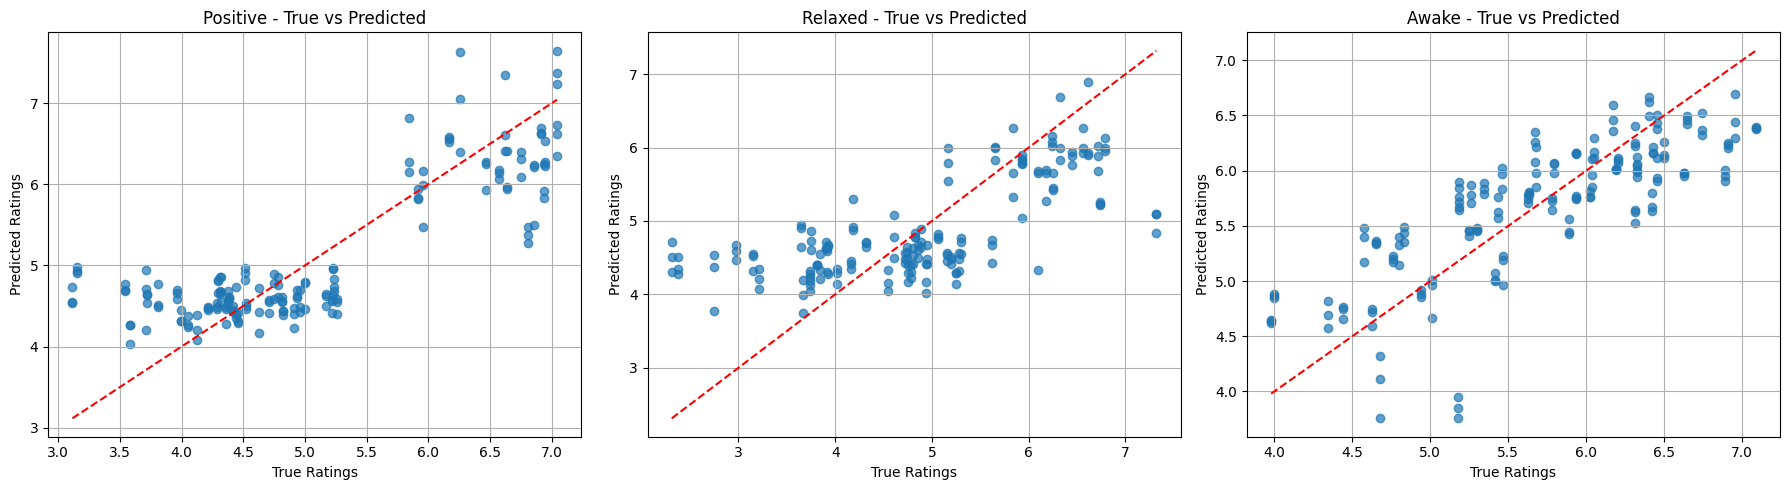

In [7]:
#Test to see if the model has been trained correctly
print("\n✅✅ Training Complete!")
print(f"→ Number of audio samples used: {X.shape[0]}")
print(f"→ Number of features per sample: {X.shape[1]}")
print(f"→ Feature names (first 5): {list(X.columns[:5])}")
print(f"→ Target dimensions: {list(Y.columns)}")


#Providing visual aid to see if lasso regression was done correctly
# Create one row with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns
fig.subplots_adjust(wspace=0.4)  # Add space between plots

# Loop through each dimension and plot on its respective axis
for ax, (col, data) in zip(axes, lasso_predictions.items()):
    ax.scatter(data['y_true'], data['y_pred'], alpha=0.7)
    ax.plot([min(data['y_true']), max(data['y_true'])],
            [min(data['y_true']), max(data['y_true'])], 'r--')
    ax.set_title(f"{col.capitalize()} - True vs Predicted")
    ax.set_xlabel("True Ratings")
    ax.set_ylabel("Predicted Ratings")
    ax.grid(True)

plt.tight_layout()
plt.show()

# Evaluate

In [9]:
print("📊 Lasso Regression Statistics (Repeated CV)\n" + "-" * 45)

maes, rmses, pearsons, r2s = [], [], [], []

for col, data in lasso_predictions.items():
    y_true = data['y_true']
    y_pred = data['y_pred']
    model = lasso_models[col]

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    r, _ = pearsonr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    maes.append(mae)
    rmses.append(rmse)
    pearsons.append(r)
    r2s.append(r2)

    print(f"\n📈 Dimension: {col}")
    print("→ MAE:", round(mae, 4))
    print("→ RMSE:", round(rmse, 4))
    print("→ Pearson Correlation:", round(r, 4))
    print("→ Non-zero Coefficients:", np.sum(model.coef_ != 0))
    print("→ R² Score:", round(r2, 4))

# Summary
print("\n📊 Overall Summary\n" + "-" * 25)
print("Average MAE:", round(np.mean(maes), 4))
print("Average RMSE:", round(np.mean(rmses), 4))
print("Average Pearson Correlation:", round(np.mean(pearsons), 4))
print("Average R² Score:", round(np.mean(r2s), 4))


📊 Lasso Regression Statistics (Repeated CV)
---------------------------------------------

📈 Dimension: positive
→ MAE: 0.4806
→ RMSE: 0.3837
→ Pearson Correlation: 0.8341
→ Non-zero Coefficients: 8
→ R² Score: 0.6923

📈 Dimension: relaxed
→ MAE: 0.6848
→ RMSE: 0.7437
→ Pearson Correlation: 0.7086
→ Non-zero Coefficients: 6
→ R² Score: 0.4784

📈 Dimension: awake
→ MAE: 0.394
→ RMSE: 0.2282
→ Pearson Correlation: 0.7926
→ Non-zero Coefficients: 9
→ R² Score: 0.6281

📊 Overall Summary
-------------------------
Average MAE: 0.5198
Average RMSE: 0.4519
Average Pearson Correlation: 0.7785
Average R² Score: 0.5996
